# Importing necessary packages

In [ ]:
# Importing necessary packages
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt
import statsmodels.api as sm
import yfinance as yf
import pandas_ta
from statsmodels.regression.rolling import RollingOLS
import pandas_datareader.data as web
import warnings

# Ignore warnings
warnings.filterwarnings('ignore')

#1)  Load S&P 500 symbols

In [ ]:
# Load S&P 500 symbols
sp500 = pd.read_html('https://en.wikipedia.org/wiki/List_of_S%26P_500_companies')[0]
sp500['Symbol'] = sp500['Symbol'].str.replace('.', '-')
symbols_list = sp500['Symbol'].unique().tolist()

# Define date range
end_date = '2023-09-27'
start_date = pd.to_datetime(end_date) - pd.DateOffset(years=8)

In [ ]:
# Download stock price data
sp500_prices = yf.download(tickers=symbols_list, start=start_date, end=end_date).stack()
sp500_prices.index.names = ['date', 'ticker']
sp500_prices.columns = sp500_prices.columns.str.lower()

In [ ]:
sp500_prices.head()

Price              adj close      close       high        low       open  \
date       ticker                                                          
2015-09-28 A       31.080612  33.369999  34.270000  33.320000  34.130001   
           AAL     37.266270  39.080002  40.180000  38.639999  39.869999   
           AAPL    25.415133  28.110001  28.642500  28.110001  28.462500   
           ABBV    35.806366  52.500000  55.430000  52.340000  55.389999   
           ABT     32.931065  39.060001  40.740002  39.000000  40.740002   

Price                   volume  
date       ticker               
2015-09-28 A         2615400.0  
           AAL       9635900.0  
           AAPL    208436000.0  
           ABBV     15123000.0  
           ABT      17219300.0

In [ ]:
sp500_prices.tail()

Price               adj close       close        high         low        open  \
date       ticker                                                               
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211006  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131119  176.869995  178.449997  176.270004  176.580002   

Price                 volume  
date       ticker             
2023-09-26 XYL     1322400.0  
           YUM     1500600.0  
           ZBH     3610500.0  
           ZBRA     355400.0  
           ZTS     1463200.0

**2) Calculate features and technical indicators for each stock.**

    Garman-Klass Volatility
    RSI(Relative Strength Index)
    Bollinger Bands
    ATR(Average True Range)
    MACD(Moving Average Convergence Divergence)
    Dollar Volume

In [ ]:
sp500_prices['garman_klass_vol'] = ((np.log(sp500_prices['high'])-np.log(sp500_prices['low']))**2)/2-(2*np.log(2)-1)*((np.log(sp500_prices['adj close'])-np.log(sp500_prices['open']))**2)

sp500_prices['rsi'] = sp500_prices.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.rsi(close=x, length=20))

sp500_prices['bb_low'] = sp500_prices.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,0])

sp500_prices['bb_mid'] = sp500_prices.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,1])

sp500_prices['bb_high'] = sp500_prices.groupby(level=1)['adj close'].transform(lambda x: pandas_ta.bbands(close=np.log1p(x), length=20).iloc[:,2])

def compute_atr(stock_data):
    atr = pandas_ta.atr(high=stock_data['high'],
                        low=stock_data['low'],
                        close=stock_data['close'],
                        length=14)
    return atr.sub(atr.mean()).div(atr.std())

sp500_prices['atr'] = sp500_prices.groupby(level=1, group_keys=False).apply(compute_atr)

def compute_macd(close):
    macd = pandas_ta.macd(close=close, length=20).iloc[:,0]
    return macd.sub(macd.mean()).div(macd.std())

sp500_prices['macd'] = sp500_prices.groupby(level=1, group_keys=False)['adj close'].apply(compute_macd)

sp500_prices['dollar_volume'] = (sp500_prices['adj close']*sp500_prices['volume'])/1e6

sp500_prices

Price               adj close       close        high         low        open  \
date       ticker                                                               
2015-09-28 A        31.080612   33.369999   34.270000   33.320000   34.130001   
           AAL      37.266270   39.080002   40.180000   38.639999   39.869999   
           AAPL     25.415133   28.110001   28.642500   28.110001   28.462500   
           ABBV     35.806366   52.500000   55.430000   52.340000   55.389999   
           ABT      32.931065   39.060001   40.740002   39.000000   40.740002   
...                       ...         ...         ...         ...         ...   
2023-09-26 XYL      88.736298   89.519997   90.849998   89.500000   90.379997   
           YUM     122.211006  124.010002  124.739998  123.449997  124.239998   
           ZBH     111.534821  112.459999  117.110001  112.419998  116.769997   
           ZBRA    223.960007  223.960007  226.649994  222.580002  225.970001   
           ZTS     175.131119  176.869995  178.449997  176.270004  176.580002   

Price                   volume  garman_klass_vol        rsi    bb_low  \
date       ticker                                                       
2015-09-28 A         2615400.0         -0.002989        NaN       NaN   
           AAL       9635900.0         -0.000998        NaN       NaN   
           AAPL    208436000.0         -0.004778        NaN       NaN   
           ABBV     15123000.0         -0.071880        NaN       NaN   
           ABT      17219300.0         -0.016539        NaN       NaN   
...                        ...               ...        ...       ...   
2023-09-26 XYL       1322400.0         -0.000018  26.146746  4.485761   
           YUM       1500600.0         -0.000051  36.057164  4.811707   
           ZBH       3610500.0          0.000022  31.893227  4.745884   
           ZBRA       355400.0          0.000133  29.494977  5.400991   
           ZTS       1463200.0          0.000049  42.623458  5.153746   

Price                bb_mid   bb_high       atr      macd  dollar_volume  
date       ticker                                                         
2015-09-28 A            NaN       NaN       NaN       NaN      81.288233  
           AAL          NaN       NaN       NaN       NaN     359.094048  
           AAPL         NaN       NaN       NaN       NaN    5297.428562  
           ABBV         NaN       NaN       NaN       NaN     541.499673  
           ABT          NaN       NaN       NaN       NaN     567.049881  
...                     ...       ...       ...       ...            ...  
2023-09-26 XYL     4.567684  4.649607  0.034424 -2.159879     117.344880  
           YUM     4.841672  4.871637  0.142517 -1.363306     183.389836  
           ZBH     4.785551  4.825217 -0.381346 -0.881471     402.696470  
           ZBRA    5.539167  5.677342 -0.056874 -1.601131      79.595386  
           ZTS     5.212559  5.271371  0.651965 -1.188422     256.251853  

[986432 rows x 14 columns]

**3)Aggregate data to a monthly level and filter for the top 150 most liquid stocks each month.**
**To reduce training time and facilitate feature and strategy experimentation, convert the business-daily data to a month-end frequency.**

In [ ]:
last_cols = [c for c in sp500_prices.columns.unique(0) if c not in ['dollar_volume', 'volume', 'open',
                                                          'high', 'low', 'close']]

data = (pd.concat([sp500_prices.unstack('ticker')['dollar_volume'].resample('M').mean().stack('ticker').to_frame('dollar_volume'),
                   sp500_prices.unstack()[last_cols].resample('M').last().stack('ticker')],
                  axis=1)).dropna()

data

dollar_volume   adj close       atr   bb_high    bb_low  \
date       ticker                                                            
2015-11-30 A          135.740899   38.950890 -1.033382  3.689080  3.544191   
           AAL        287.915806   39.429928  0.189119  3.827636  3.672028   
           AAPL      4023.983909   26.854137 -0.965970  3.368302  3.281679   
           ABBV       334.491189   40.025845 -0.524698  3.814247  3.717771   
           ABT        210.542079   38.091480 -1.063278  3.694603  3.650901   
...                          ...         ...       ...       ...       ...   
2023-09-30 OTIS       154.361755   78.356506 -1.028320  4.460712  4.370137   
           ABNB      1633.500725  132.279999 -1.006939  5.024801  4.857047   
           CEG        196.670369  107.862030 -0.436215  4.732493  4.652147   
           GEHC       212.197215   66.105713 -0.893478  4.270142  4.155071   
           KVUE       670.804278   20.006195 -0.899746  3.164168  3.014275   

                     bb_mid  garman_klass_vol      macd        rsi  
date       ticker                                                   
2015-11-30 A       3.616636         -0.002098  0.568319  73.544130  
           AAL     3.749832         -0.000966 -0.413408  40.794346  
           AAPL    3.324990         -0.003307 -0.151141  54.676770  
           ABBV    3.766009         -0.062372  0.125472  49.466827  
           ABT     3.672752         -0.011927  0.333748  57.238756  
...                     ...               ...       ...        ...  
2023-09-30 OTIS    4.415425         -0.000097 -1.534535  33.116290  
           ABNB    4.940924          0.000213 -0.037854  44.494127  
           CEG     4.692320          0.000131  0.366876  55.245485  
           GEHC    4.212607          0.000185 -1.116463  40.922316  
           KVUE    3.089221         -0.000159 -1.435620  35.706355  

[46553 rows x 9 columns]

In [ ]:
# For each month, filter the top 150 most liquid stocks based on dollar volume
def filter_top_stocks(group, top_n=150):
    return group.groupby('date')['dollar_volume'].nlargest(top_n).reset_index(level=0, drop=True).reset_index()

# Apply the filtering function
monthly_data_filtered = data.groupby(level='date', group_keys=False).apply(filter_top_stocks)

monthly_data_filtered

,date,ticker,dollar_volume
0,2015-11-30,GE,4391.933097
1,2015-11-30,AAPL,4023.983909
2,2015-11-30,META,2895.657536
3,2015-11-30,AMZN,2869.513198
4,2015-11-30,NFLX,1858.387317
...,...,...,...
145,2023-09-30,ICE,318.586738
146,2023-09-30,NXPI,318.560429
147,2023-09-30,MCK,317.406505
148,2023-09-30,PLD,312.928947


**Calculate the 5-year rolling average of dollar volume for each stocks before filtering.**

In [ ]:
data['dollar_volume'] = (
    data.loc[:, 'dollar_volume']  # Use .loc to select 'dollar_volume'
    .unstack('ticker')           # Unstack 'ticker' if it’s part of the index
    .rolling(5*12, min_periods=12)  # Apply a rolling window of 5 years
    .mean()                      # Compute the rolling mean
    .stack()                     # Stack back to the original multi-index format
)
data['dollar_vol_rank'] = (data.groupby('date')['dollar_volume'].rank(ascending=False))

data = data[data['dollar_vol_rank']<150].drop(['dollar_volume', 'dollar_vol_rank'], axis=1)

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2016-10-31 AAL      39.134331  0.401619  3.706314  3.604673  3.655494   
           AAPL     26.212477 -1.038461  3.351997  3.294237  3.323117   
           ABBV     39.878788 -0.893043  3.852823  3.744517  3.798670   
           ABT      34.112484 -1.035050  3.650426  3.549492  3.599959   
           ACN     103.117393 -0.996294  4.656283  4.633009  4.644646   
...                       ...       ...       ...       ...       ...   
2023-09-30 XOM     113.372101  0.601759  4.767283  4.687091  4.727187   
           MRNA     98.120003 -0.529511  4.788149  4.582514  4.685332   
           UBER     44.270000 -0.746098  3.917801  3.806654  3.862227   
           CRWD    160.479996 -0.744862  5.181204  5.026187  5.103696   
           ABNB    132.279999 -1.006939  5.024801  4.857047  4.940924   

                   garman_klass_vol      macd        rsi  
date       ticker                                         
2016-10-31 AAL            -0.000176  1.127774  62.203574  
           AAPL           -0.002468 -0.195865  49.891106  
           ABBV           -0.049190 -0.760498  27.477875  
           ABT            -0.008074 -0.651383  38.008893  
           ACN            -0.005023 -0.136004  53.823633  
...                             ...       ...        ...  
2023-09-30 XOM            -0.000065  1.399851  59.440188  
           MRNA            0.000146 -0.376899  38.747314  
           UBER            0.000441 -0.133973  45.005268  
           CRWD            0.000144  0.245950  51.534803  
           ABNB            0.000213 -0.037854  44.494127  

[12516 rows x 8 columns]

4. Calculate Monthly Returns for different time horizons as features.
To capture time series dynamics that reflect, for example, momentum patterns, we compute historical returns using the method .pct_change(lag), that is, returns over various monthly periods as identified by lags.

In [ ]:
def calculate_returns(sp500_prices):

    outlier_cutoff = 0.005

    lags = [1, 2, 3, 6, 9, 12]

    for lag in lags:

        sp500_prices[f'return_{lag}m'] = (sp500_prices['adj close']
                              .pct_change(lag)
                              .pipe(lambda x: x.clip(lower=x.quantile(outlier_cutoff),
                                                     upper=x.quantile(1-outlier_cutoff)))
                              .add(1)
                              .pow(1/lag)
                              .sub(1))
    return sp500_prices


data = data.groupby(level=1, group_keys=False).apply(calculate_returns).dropna()

data

adj close       atr   bb_high    bb_low    bb_mid  \
date       ticker                                                       
2017-10-31 AAL      45.534168  1.010422  3.994389  3.849110  3.921750   
           AAPL     39.713894 -0.906398  3.688475  3.594730  3.641603   
           ABBV     66.876793  0.375915  4.280405  4.187696  4.234050   
           ABT      48.237465 -1.039871  3.934519  3.887385  3.910952   
           ACN     128.834702 -0.986001  4.877691  4.798335  4.838013   
...                       ...       ...       ...       ...       ...   
2023-09-30 XOM     113.372101  0.601759  4.767283  4.687091  4.727187   
           MRNA     98.120003 -0.529511  4.788149  4.582514  4.685332   
           UBER     44.270000 -0.746098  3.917801  3.806654  3.862227   
           CRWD    160.479996 -0.744862  5.181204  5.026187  5.103696   
           ABNB    132.279999 -1.006939  5.024801  4.857047  4.940924   

                   garman_klass_vol      macd        rsi  return_1m  \
date       ticker                                                     
2017-10-31 AAL            -0.000363 -0.020264  41.051795  -0.014108   
           AAPL           -0.001055 -0.039127  69.196644   0.096807   
           ABBV           -0.036142  0.474520  55.247841   0.022728   
           ABT            -0.005677  0.275617  53.844910   0.021275   
           ACN            -0.004274  0.351862  69.365328   0.064180   
...                             ...       ...        ...        ...   
2023-09-30 XOM            -0.000065  1.399851  59.440188   0.046947   
           MRNA            0.000146 -0.376899  38.747314  -0.132219   
           UBER            0.000441 -0.133973  45.005268  -0.062672   
           CRWD            0.000144  0.245950  51.534803  -0.015641   
           ABNB            0.000213 -0.037854  44.494127   0.005549   

                   return_2m  return_3m  return_6m  return_9m  return_12m  
date       ticker                                                          
2017-10-31 AAL      0.022981  -0.023860   0.016495   0.007008    0.012702  
           AAPL     0.015250   0.044955   0.028875   0.038941    0.035228  
           ABBV     0.098590   0.091379   0.056495   0.047273    0.044026  
           ABT      0.034308   0.034801   0.038672   0.031320    0.029294  
           ACN      0.048455   0.037203   0.028692   0.027398    0.018728  
...                      ...        ...        ...        ...         ...  
2023-09-30 XOM      0.046139   0.030496   0.012838   0.008747    0.027037  
           MRNA    -0.086803  -0.068763  -0.071952  -0.064976   -0.015431  
           UBER    -0.053920   0.008422   0.057244   0.066838    0.043691  
           CRWD    -0.003656   0.029981   0.026391   0.047942   -0.002216  
           ABNB    -0.067704   0.010603   0.010289   0.049124    0.019401  

[10342 rows x 14 columns]

**5.Download Fama-French Factors and Calculate Rolling Factor Betas.**
**We will use Fama-French data to estimate asset exposure to common risk factors via linear regression.**

**The five Fama-French factors—market risk, size, value, operating profitability, and investment—are empirically proven to explain asset returns and are widely used to assess the risk/return profile of portfolios. Therefore, incorporating past factor exposures as financial features in models is logical.**

**We can access the historical factor returns using the pandas-datareader and estimate historical exposures using the RollingOLS rolling linear regression.**

In [ ]:
factor_data = web.DataReader('F-F_Research_Data_5_Factors_2x3',
                               'famafrench',
                               start='2010')[0].drop('RF', axis=1)

factor_data.index = factor_data.index.to_timestamp()

factor_data = factor_data.resample('M').last().div(100)

factor_data.index.name = 'date'

factor_data = factor_data.join(data['return_1m']).sort_index()

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096807
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021275
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.009617
           VZ     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.056890
           WFC    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.015500
           WMT    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.000676
           XOM    -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.046947

[10342 rows x 6 columns]

**Filter out stocks with less than 10 months of data.**

In [ ]:
observations = factor_data.groupby(level=1).size()

valid_stocks = observations[observations >= 10]

factor_data = factor_data[factor_data.index.get_level_values('ticker').isin(valid_stocks.index)]

factor_data

Mkt-RF     SMB     HML     RMW     CMA  return_1m
date       ticker                                                   
2017-10-31 AAL     0.0225 -0.0194  0.0020  0.0093 -0.0325  -0.014108
           AAPL    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.096807
           ABBV    0.0225 -0.0194  0.0020  0.0093 -0.0325   0.022728
           ABT     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.021275
           ACN     0.0225 -0.0194  0.0020  0.0093 -0.0325   0.064180
...                   ...     ...     ...     ...     ...        ...
2023-09-30 VRTX   -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.009617
           VZ     -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.056890
           WFC    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.015500
           WMT    -0.0524 -0.0181  0.0151  0.0187 -0.0082  -0.000676
           XOM    -0.0524 -0.0181  0.0151  0.0187 -0.0082   0.046947

[10318 rows x 6 columns]

**Calculate Rolling Factor Betas.**

In [ ]:
betas = (factor_data.groupby(level=1,
                            group_keys=False)
         .apply(lambda x: RollingOLS(endog=x['return_1m'],
                                     exog=sm.add_constant(x.drop('return_1m', axis=1)),
                                     window=min(24, x.shape[0]),
                                     min_nobs=len(x.columns)+1)
         .fit(params_only=True)
         .params
         .drop('const', axis=1)))

betas

Mkt-RF       SMB       HML       RMW       CMA
date       ticker                                                  
2017-10-31 AAL          NaN       NaN       NaN       NaN       NaN
           AAPL         NaN       NaN       NaN       NaN       NaN
           ABBV         NaN       NaN       NaN       NaN       NaN
           ABT          NaN       NaN       NaN       NaN       NaN
           ACN          NaN       NaN       NaN       NaN       NaN
...                     ...       ...       ...       ...       ...
2023-09-30 VRTX    0.456835 -0.444629 -0.314191 -0.077989  0.802008
           VZ      0.332723 -0.166039  0.265927  0.311102  0.108625
           WFC     1.120621  0.297484  2.062609 -0.441340 -1.519518
           WMT     0.700774 -0.313572 -0.413679 -0.141574  0.508836
           XOM     0.983098 -1.094427  1.756404 -0.640016 -0.368885

[10318 rows x 5 columns]

**Join the rolling factors data to the main features dataframe.**

In [ ]:
factors = ['Mkt-RF', 'SMB', 'HML', 'RMW', 'CMA']

data = (data.join(betas.groupby('ticker').shift()))

data.loc[:, factors] = data.groupby('ticker', group_keys=False)[factors].apply(lambda x: x.fillna(x.mean()))

data = data.drop('adj close', axis=1)

data = data.dropna()

data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 10096 entries, (Timestamp('2017-10-31 00:00:00'), 'AAL') to (Timestamp('2023-09-30 00:00:00'), 'CRWD')
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   atr               10096 non-null  float64
 1   bb_high           10096 non-null  float64
 2   bb_low            10096 non-null  float64
 3   bb_mid            10096 non-null  float64
 4   garman_klass_vol  10096 non-null  float64
 5   macd              10096 non-null  float64
 6   rsi               10096 non-null  float64
 7   return_1m         10096 non-null  float64
 8   return_2m         10096 non-null  float64
 9   return_3m         10096 non-null  float64
 10  return_6m         10096 non-null  float64
 11  return_9m         10096 non-null  float64
 12  return_12m        10096 non-null  float64
 13  Mkt-RF            10096 non-null  float64
 14  SMB               10096 non-null  float64
 15  HML       

**At this point we have to decide on what ML model and approach to use for predictions.**

**6. For each month fit a K-Means Clustering Algorithm to group similar assets based on their features.**
#**K-Means Clustering**

In [ ]:
from sklearn.cluster import KMeans
import numpy as np

# Ensure initial_centroids is defined
target_rsi_values = [30, 45, 55, 70]
initial_centroids = np.zeros((len(target_rsi_values), 18))
initial_centroids[:, 6] = target_rsi_values

# Check if 'cluster' column exists before dropping
if 'cluster' in data.columns:
    data = data.drop('cluster', axis=1)

def get_clusters(df):
    kmeans = KMeans(n_clusters=4, random_state=0, init=initial_centroids)
    df['cluster'] = kmeans.fit(df).labels_
    return df

# Drop rows with any NaN values
data = data.dropna()

# Group by date and apply clustering
try:
    data = data.groupby('date', group_keys=False).apply(get_clusters)
except Exception as e:
    print(f"Error in clustering: {e}")

data

atr   bb_high    bb_low    bb_mid  garman_klass_vol  \
date       ticker                                                             
2017-10-31 AAL     1.010422  3.994389  3.849110  3.921750         -0.000363   
           AAPL   -0.906398  3.688475  3.594730  3.641603         -0.001055   
           ABBV    0.375915  4.280405  4.187696  4.234050         -0.036142   
           ABT    -1.039871  3.934519  3.887385  3.910952         -0.005677   
           ACN    -0.986001  4.877691  4.798335  4.838013         -0.004274   
...                     ...       ...       ...       ...               ...   
2023-09-30 WMT    -0.196160  4.019915  3.984976  4.002446         -0.000041   
           XOM     0.601759  4.767283  4.687091  4.727187         -0.000065   
           MRNA   -0.529511  4.788149  4.582514  4.685332          0.000146   
           UBER   -0.746098  3.917801  3.806654  3.862227          0.000441   
           CRWD   -0.744862  5.181204  5.026187  5.103696          0.000144   

                       macd        rsi  return_1m  return_2m  return_3m  \
date       ticker                                                         
2017-10-31 AAL    -0.020264  41.051795  -0.014108   0.022981  -0.023860   
           AAPL   -0.039127  69.196644   0.096807   0.015250   0.044955   
           ABBV    0.474520  55.247841   0.022728   0.098590   0.091379   
           ABT     0.275617  53.844910   0.021275   0.034308   0.034801   
           ACN     0.351862  69.365328   0.064180   0.048455   0.037203   
...                     ...        ...        ...        ...        ...   
2023-09-30 WMT     0.400088  54.722530  -0.000676   0.010014   0.012354   
           XOM     1.399851  59.440188   0.046947   0.046139   0.030496   
           MRNA   -0.376899  38.747314  -0.132219  -0.086803  -0.068763   
           UBER   -0.133973  45.005268  -0.062672  -0.053920   0.008422   
           CRWD    0.245950  51.534803  -0.015641  -0.003656   0.029981   

                   return_6m  return_9m  return_12m    Mkt-RF       SMB  \
date       ticker                                                         
2017-10-31 AAL      0.016495   0.007008    0.012702  1.265330  1.314923   
           AAPL     0.028875   0.038941    0.035228  1.276025 -0.271593   
           ABBV     0.056495   0.047273    0.044026  0.494532  0.362680   
           ABT      0.038672   0.031320    0.029294  0.828390 -0.199397   
           ACN      0.028692   0.027398    0.018728  1.199021 -0.166371   
...                      ...        ...         ...       ...       ...   
2023-09-30 WMT      0.017574   0.016553    0.020256  0.740244 -0.259783   
           XOM      0.012838   0.008747    0.027037  1.005608 -1.051739   
           MRNA    -0.071952  -0.064976   -0.015431  1.154879  0.766422   
           UBER     0.057244   0.066838    0.043691  1.078514  1.163168   
           CRWD     0.026391   0.047942   -0.002216  0.594732 -0.940715   

                        HML       RMW       CMA  cluster  
date       ticker                                         
2017-10-31 AAL     0.600746  0.459424  0.563336        1  
           AAPL   -0.591213  0.647542  0.458386        3  
           ABBV   -0.032806  0.242183  0.164052        2  
           ABT    -0.529385  0.251775  0.970501        2  
           ACN    -0.328322  0.268153  0.168633        3  
...                     ...       ...       ...      ...  
2023-09-30 WMT    -0.522482 -0.125197  0.642482        2  
           XOM     1.707635 -0.674966 -0.284573        3  
           MRNA   -1.163095  0.593370  0.989911        1  
           UBER   -0.257055 -1.482917 -0.449948        1  
           CRWD   -0.678313 -2.449974 -0.814519        2  

[10096 rows x 19 columns]

In [ ]:
def plot_clusters(data):

    cluster_0 = data[data['cluster']==0]
    cluster_1 = data[data['cluster']==1]
    cluster_2 = data[data['cluster']==2]
    cluster_3 = data[data['cluster']==3]

    plt.scatter(cluster_0.iloc[:,0] , cluster_0.iloc[:,6] , color = 'black', label='cluster 0')
    plt.scatter(cluster_1.iloc[:,0] , cluster_1.iloc[:,6] , color = 'red', label='cluster 1')
    plt.scatter(cluster_2.iloc[:,0] , cluster_2.iloc[:,6] , color = 'blue', label='cluster 2')
    plt.scatter(cluster_3.iloc[:,0] , cluster_3.iloc[:,6] , color = 'cyan', label='cluster 3')

    plt.legend()
    plt.show()
    return

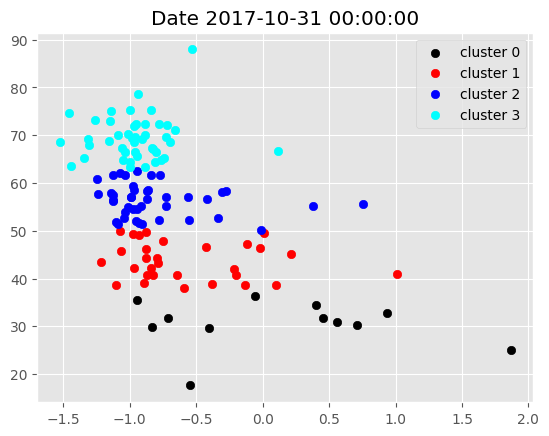

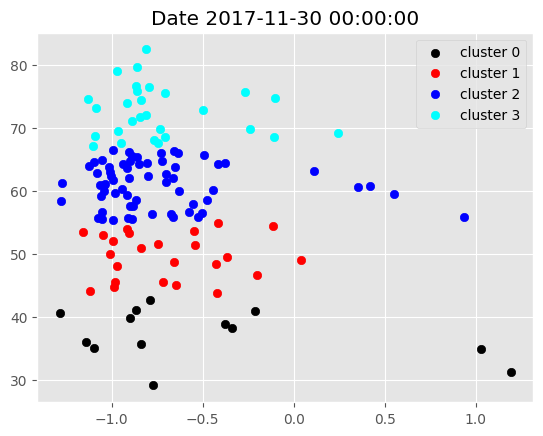

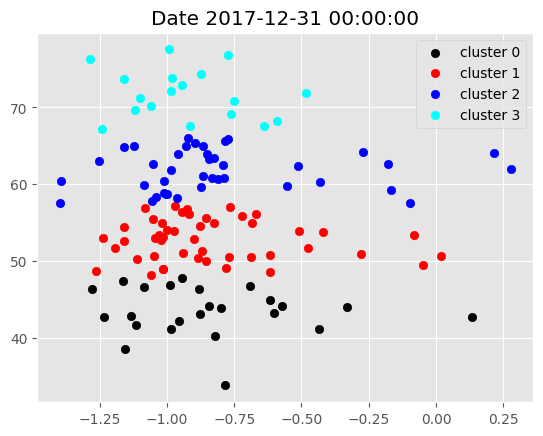

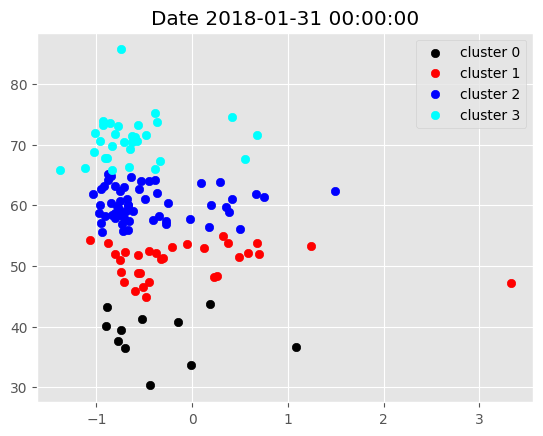

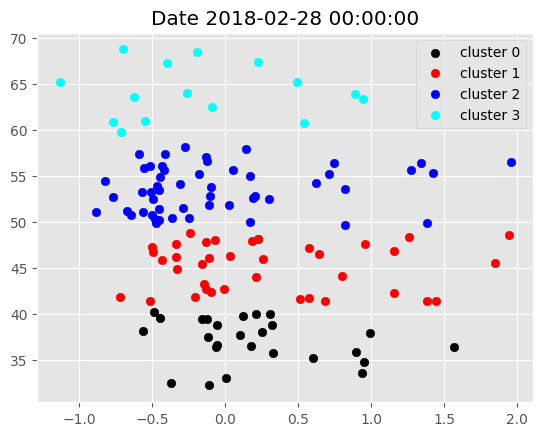

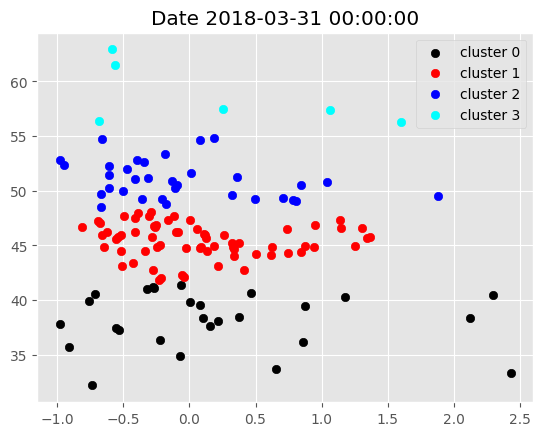

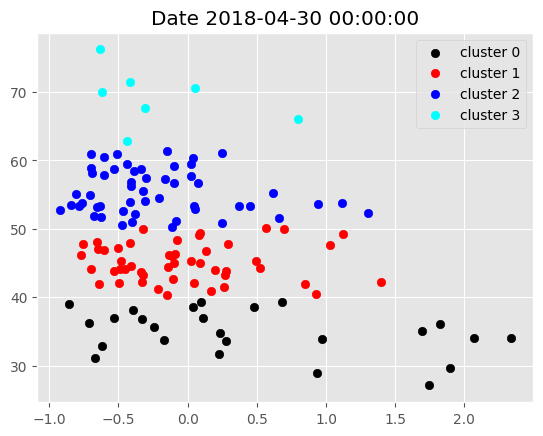

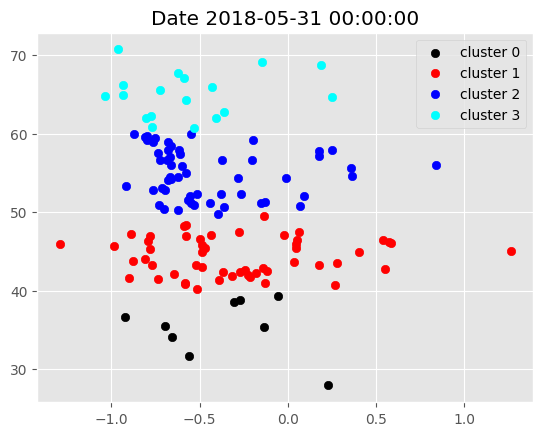

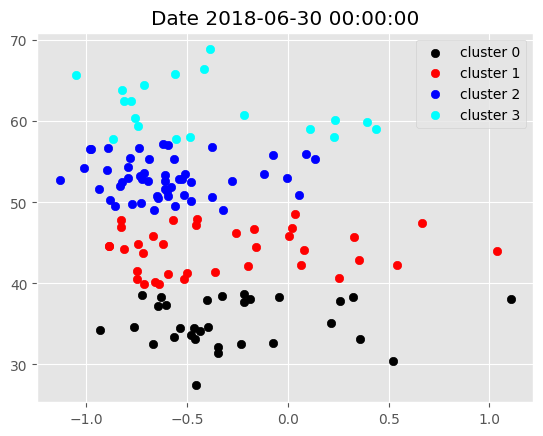

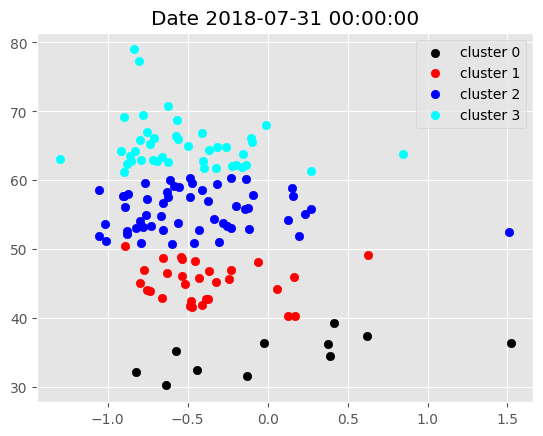

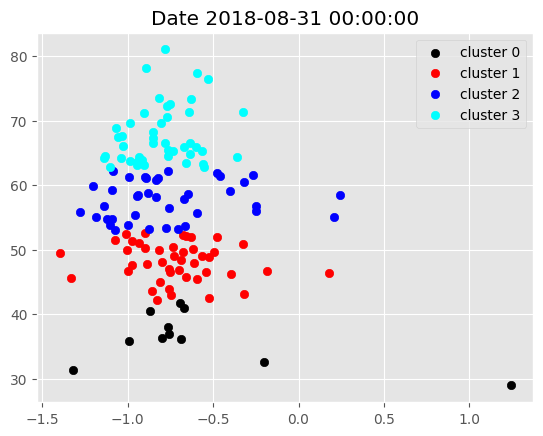

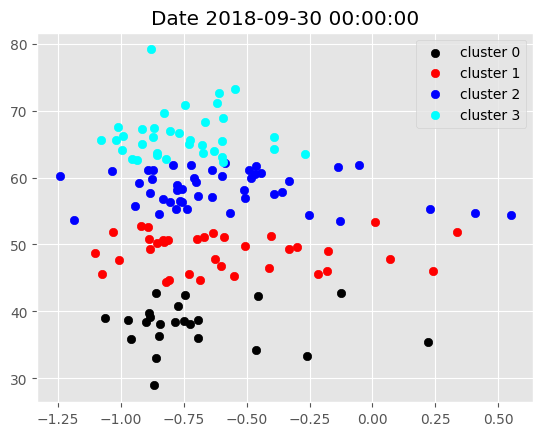

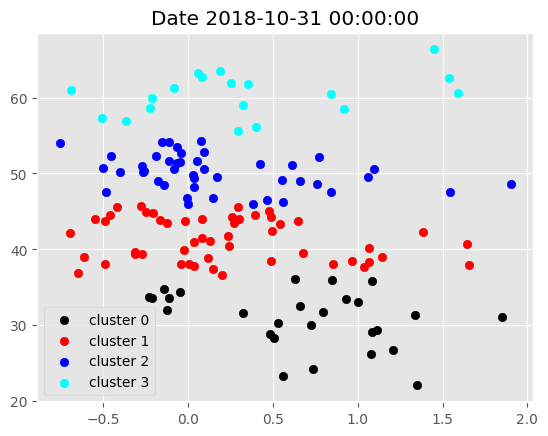

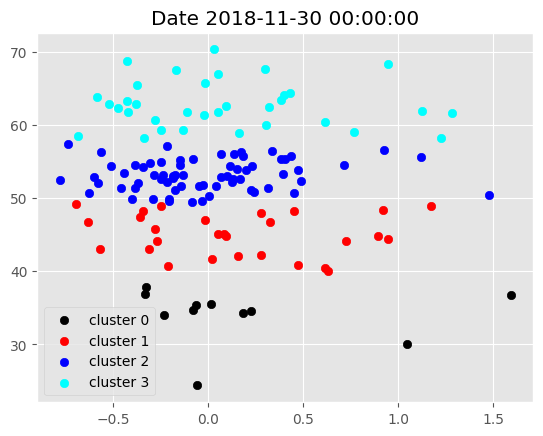

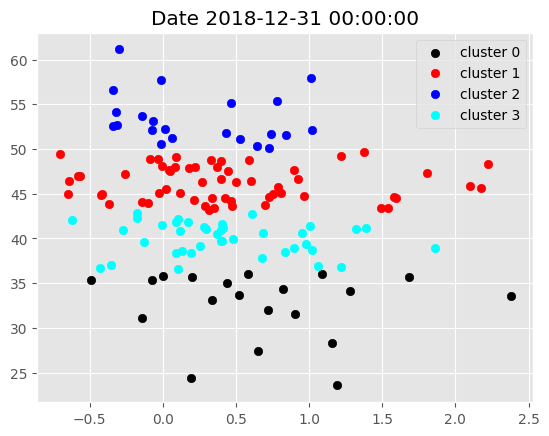

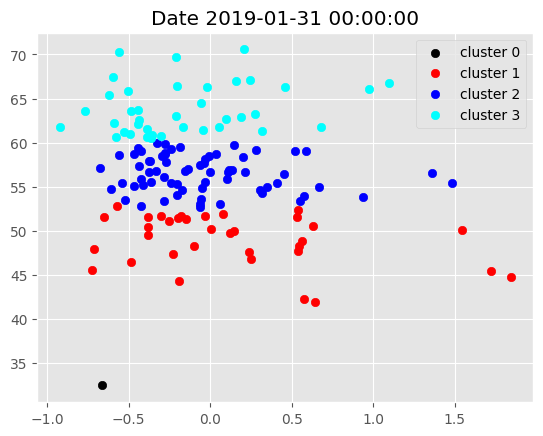

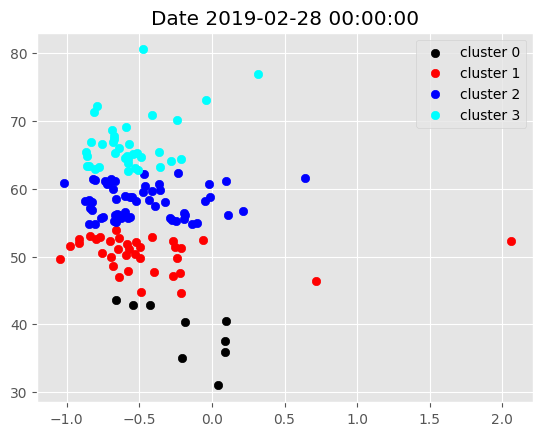

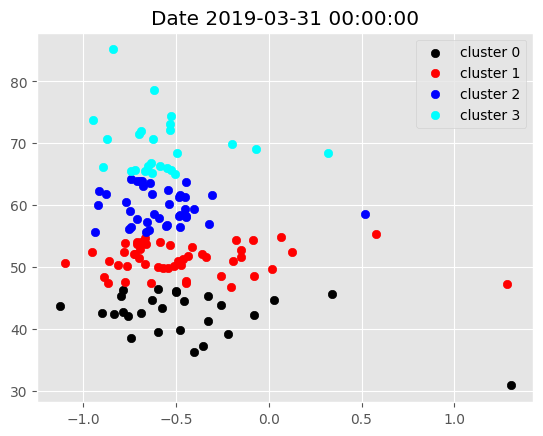

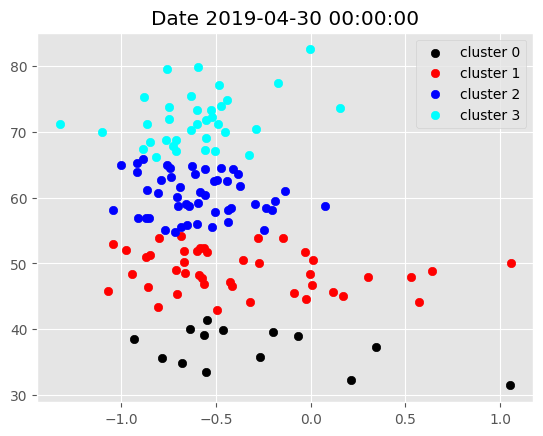

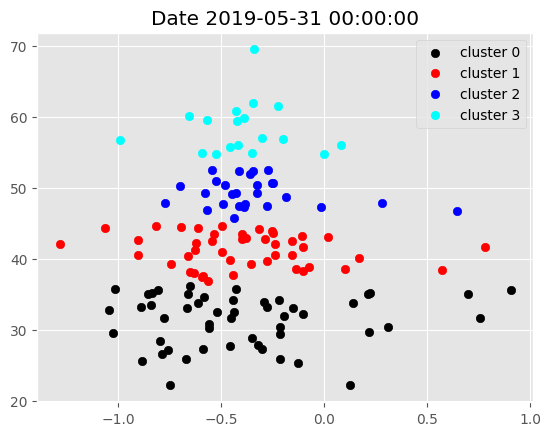

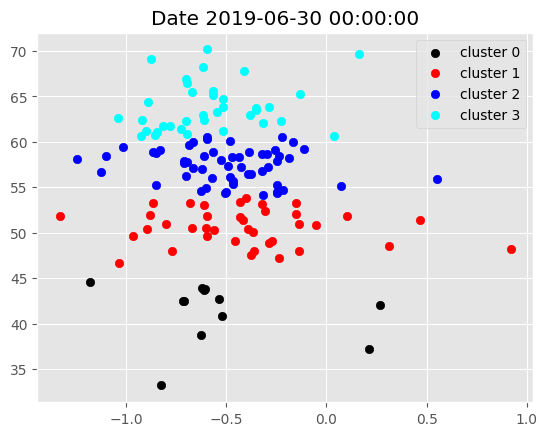

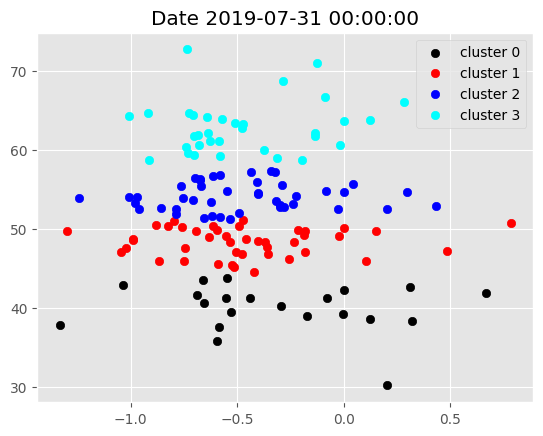

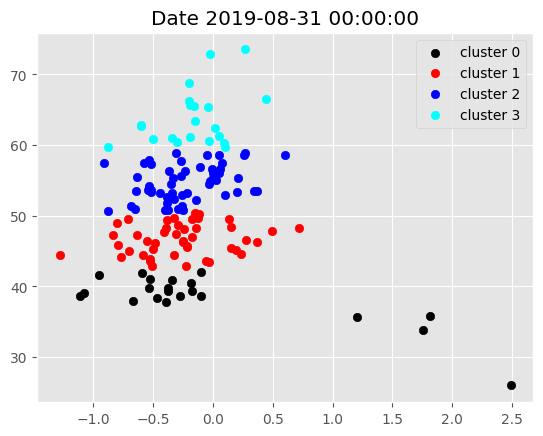

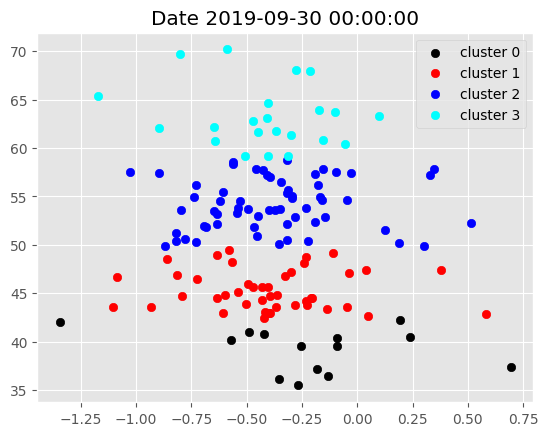

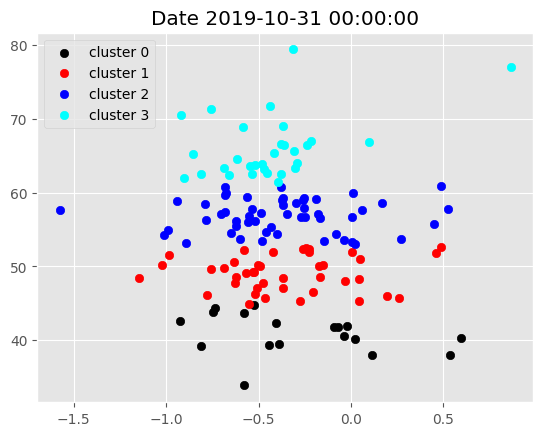

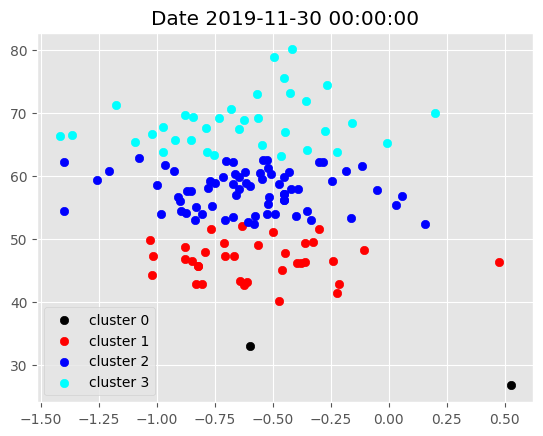

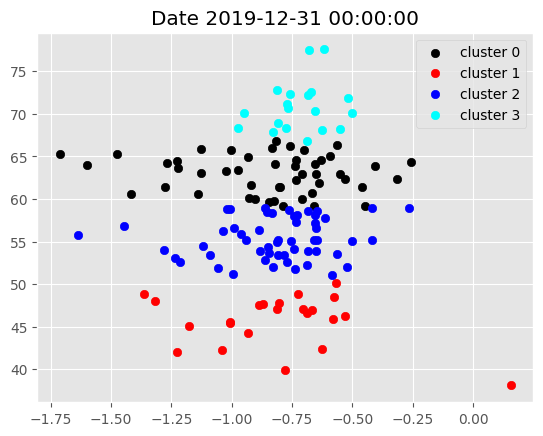

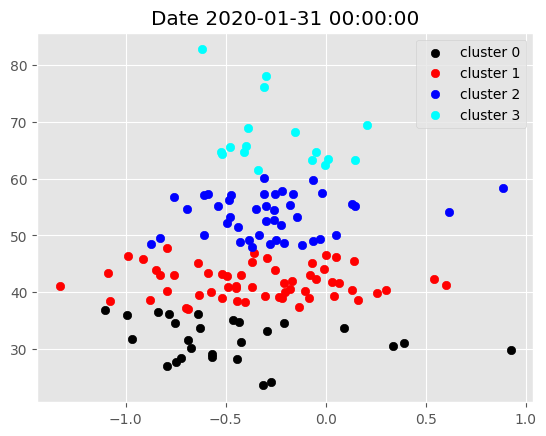

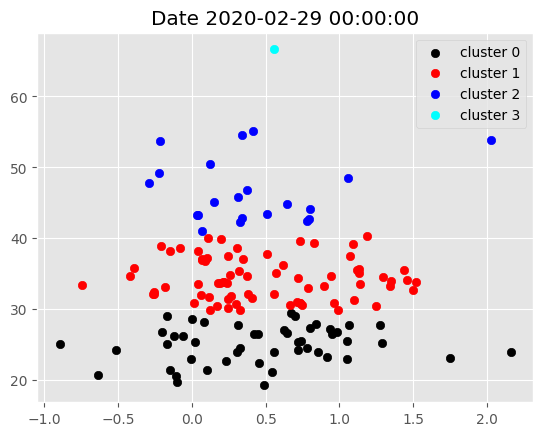

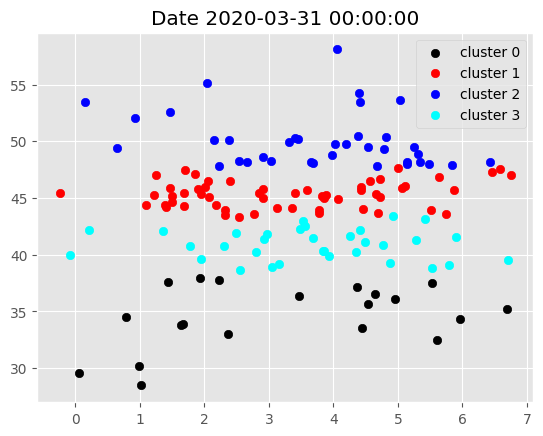

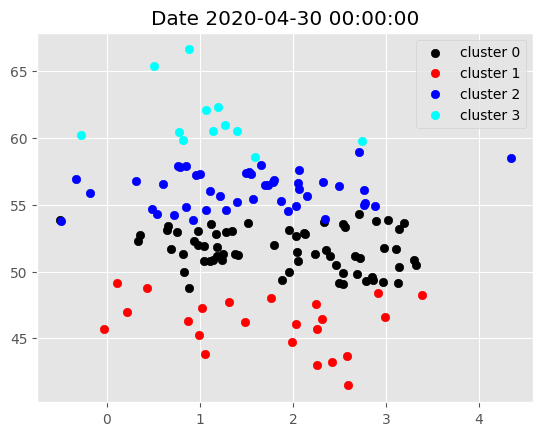

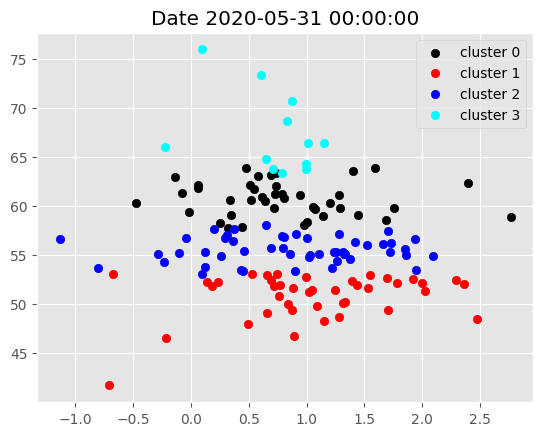

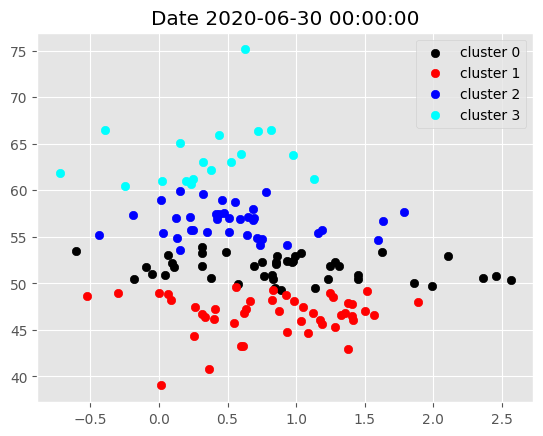

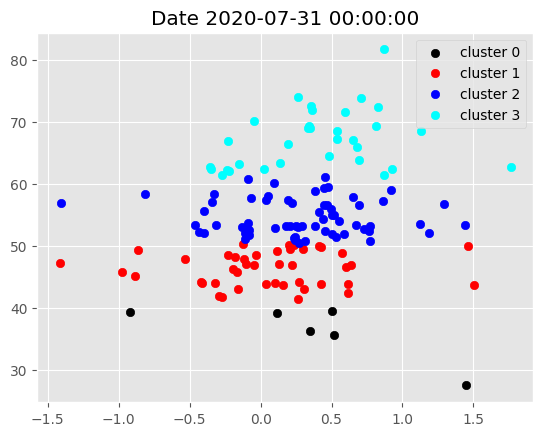

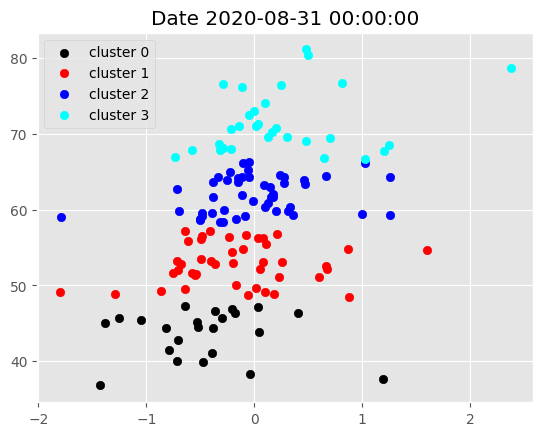

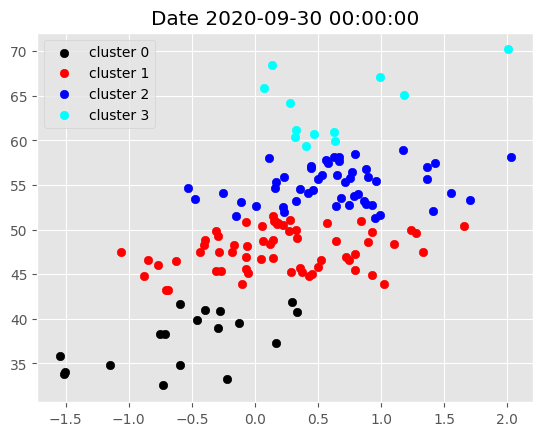

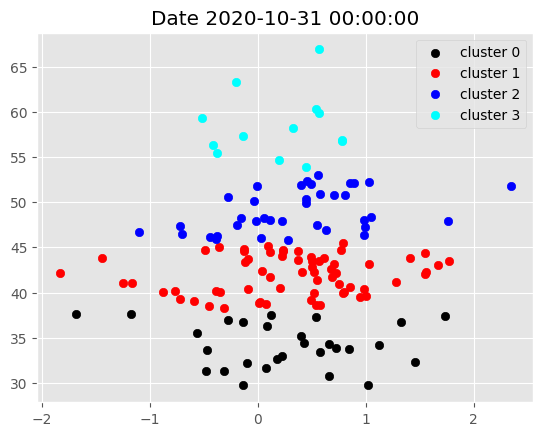

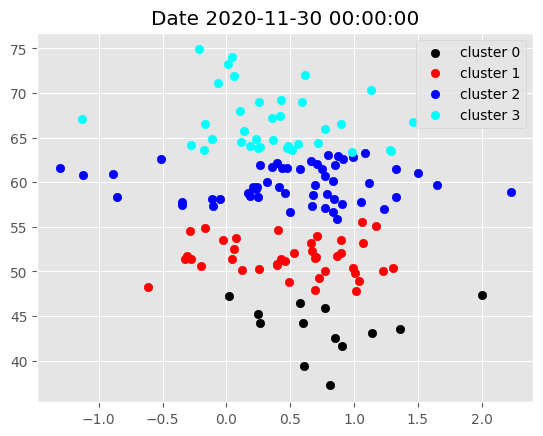

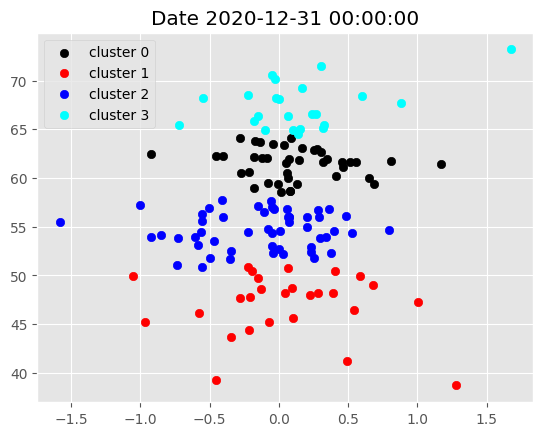

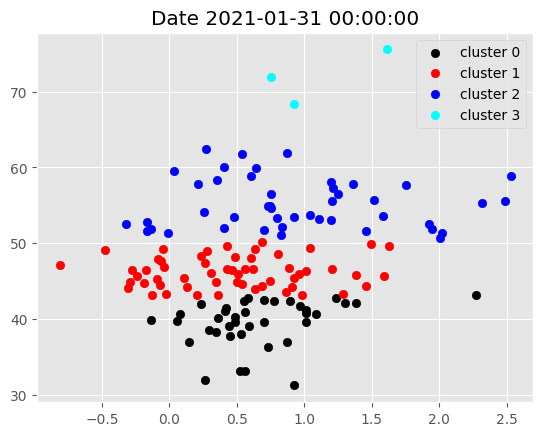

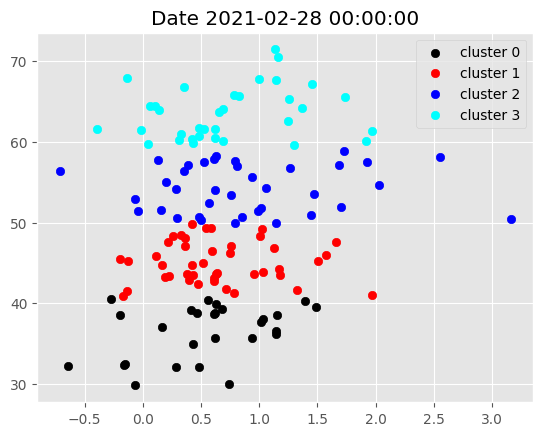

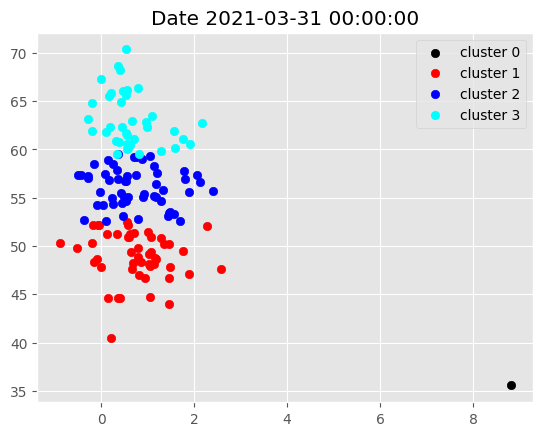

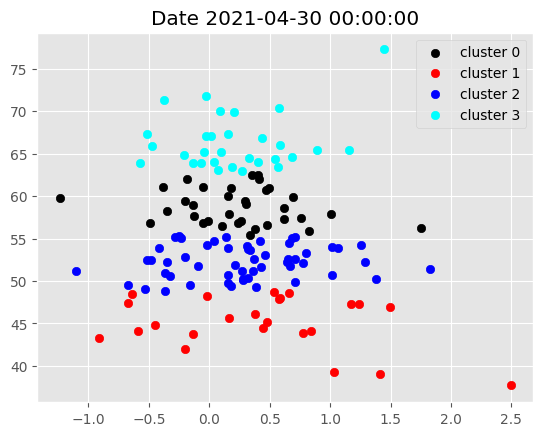

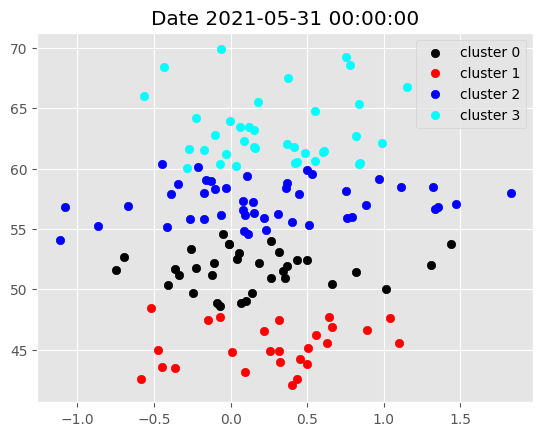

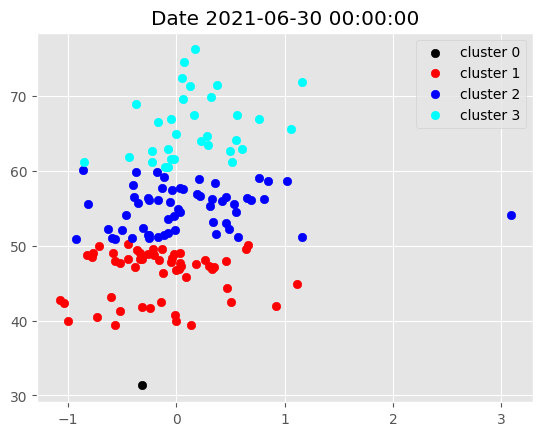

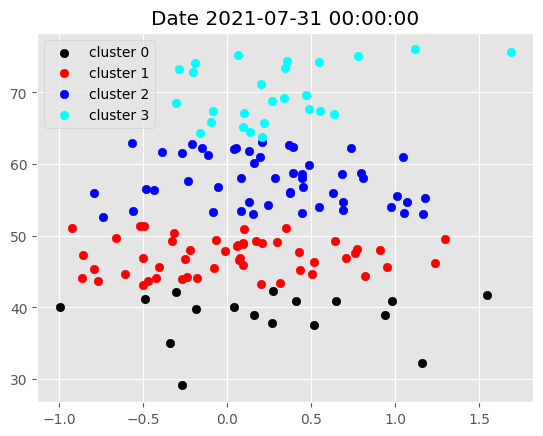

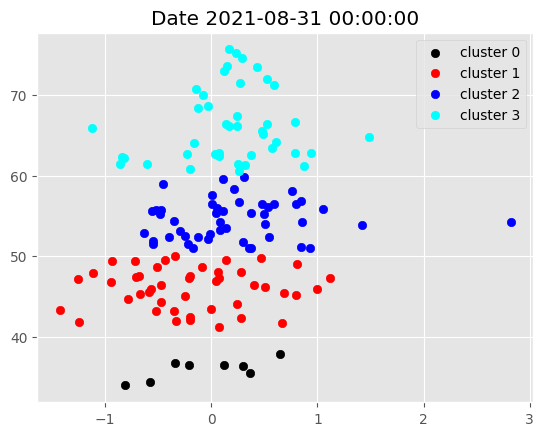

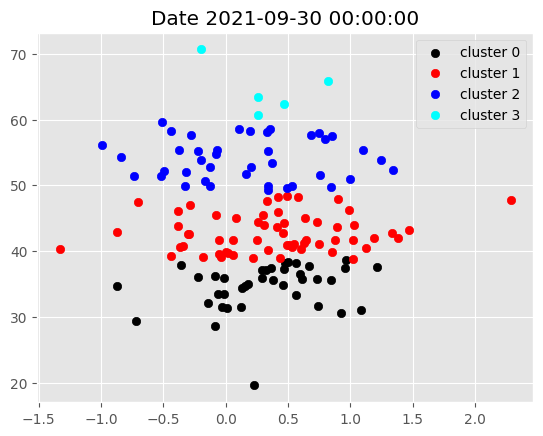

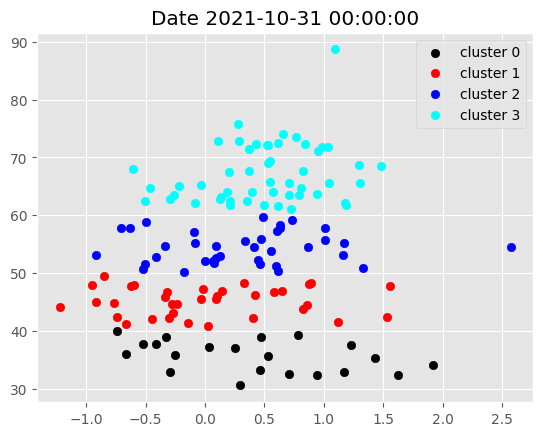

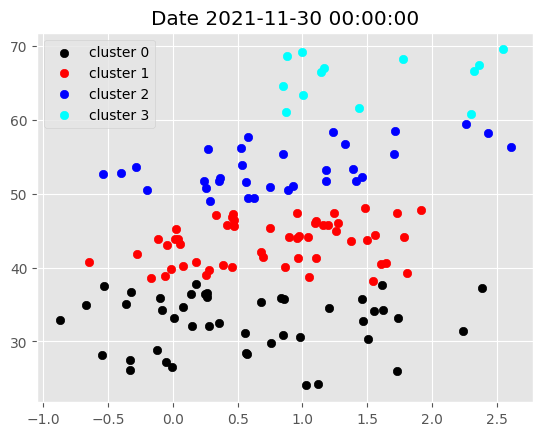

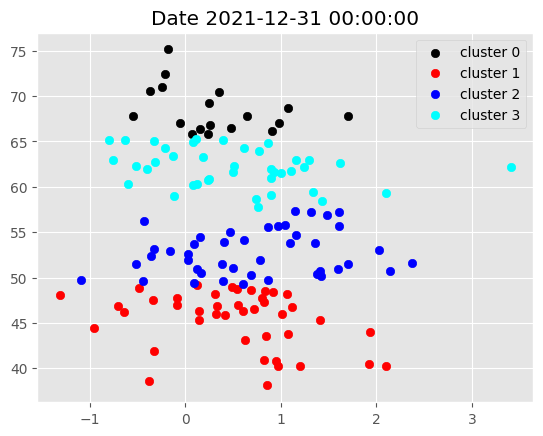

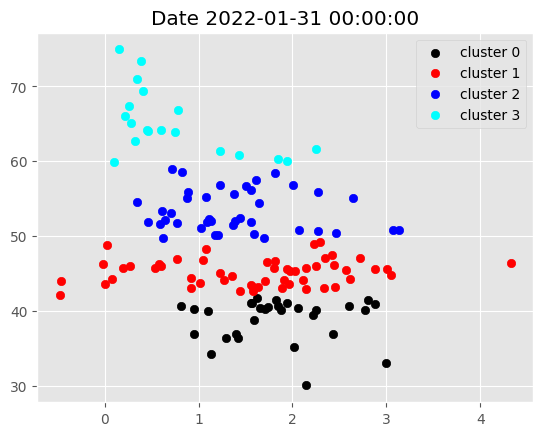

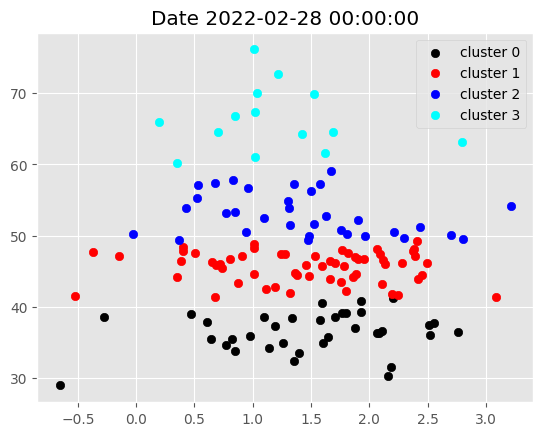

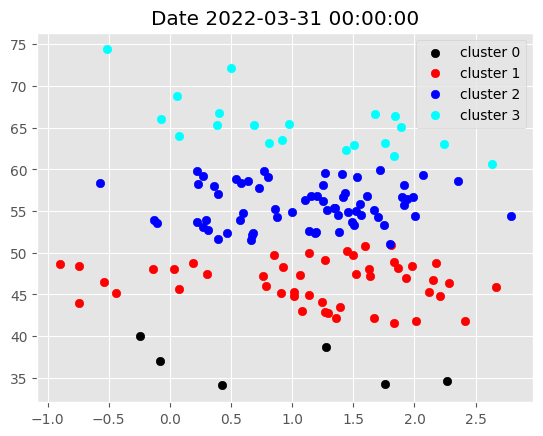

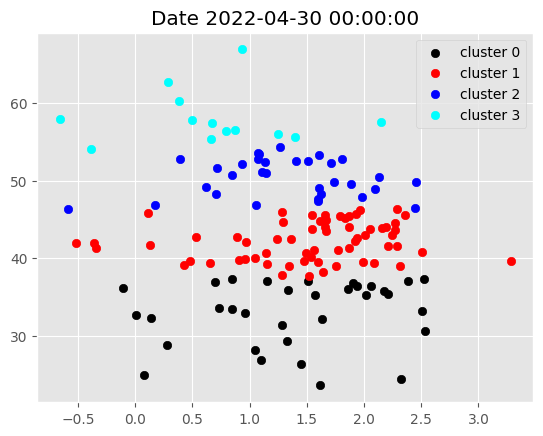

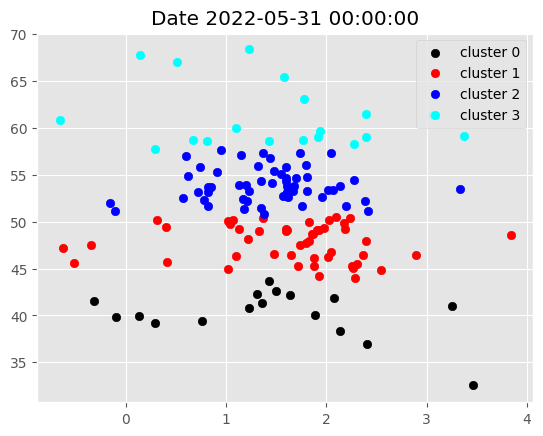

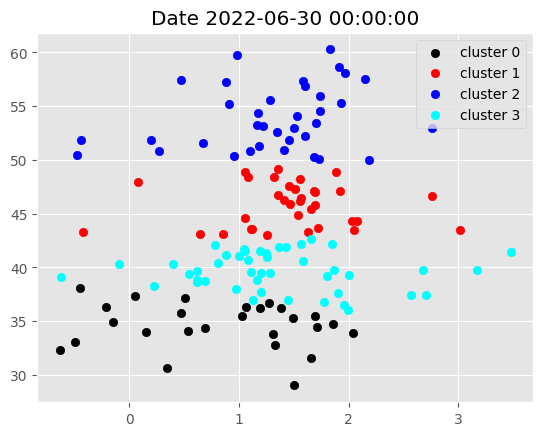

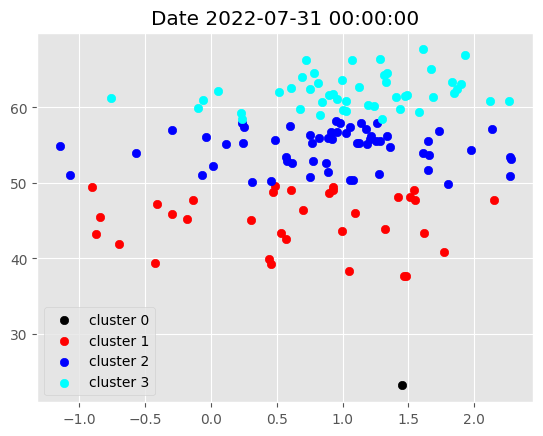

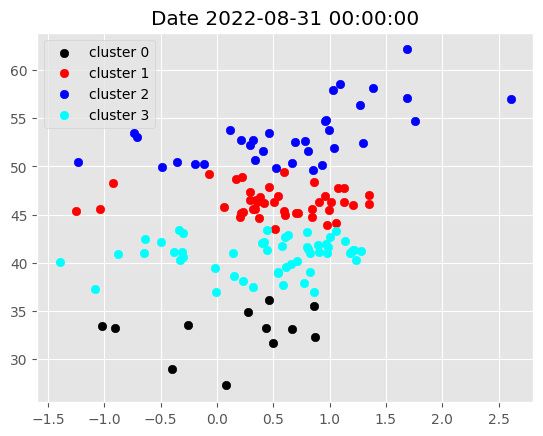

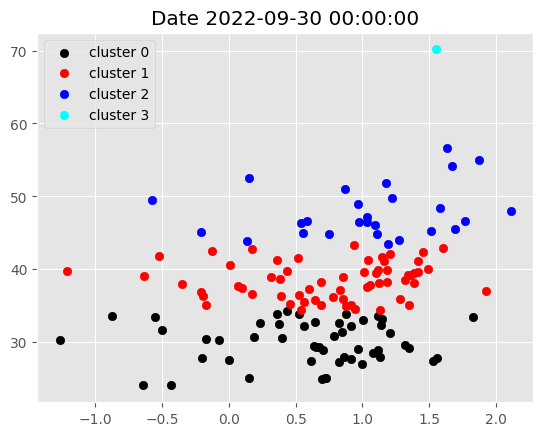

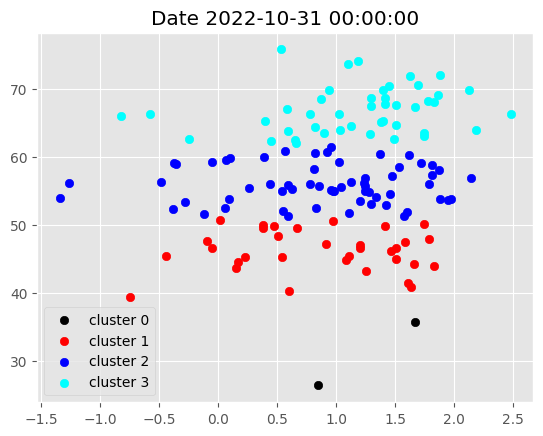

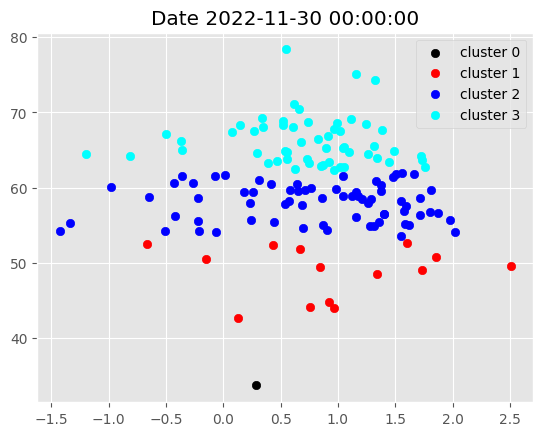

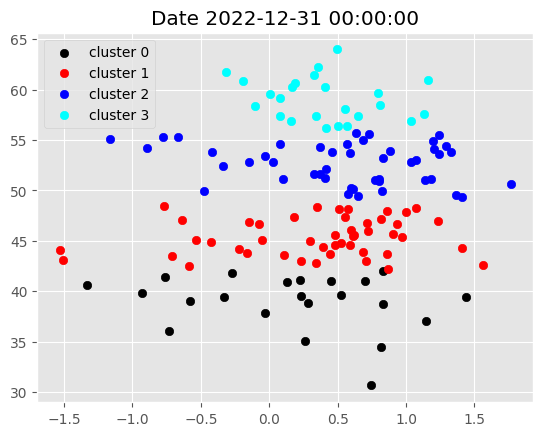

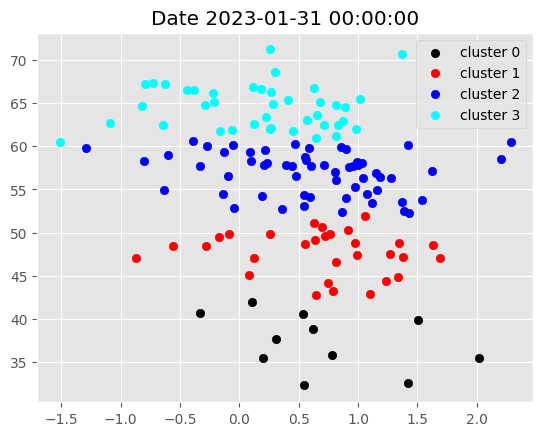

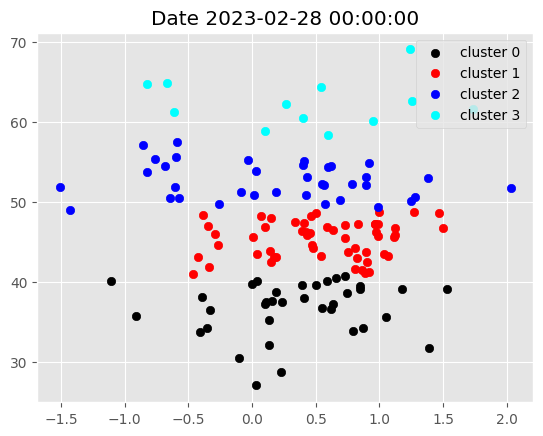

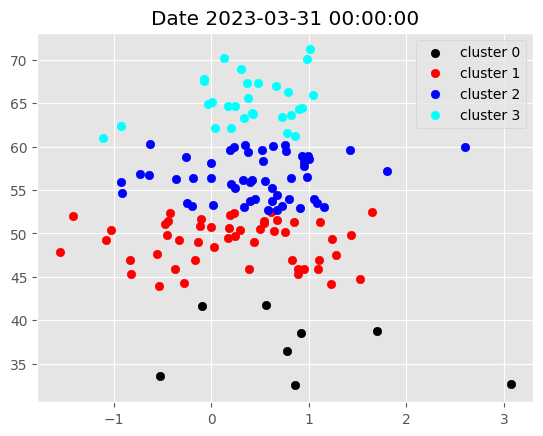

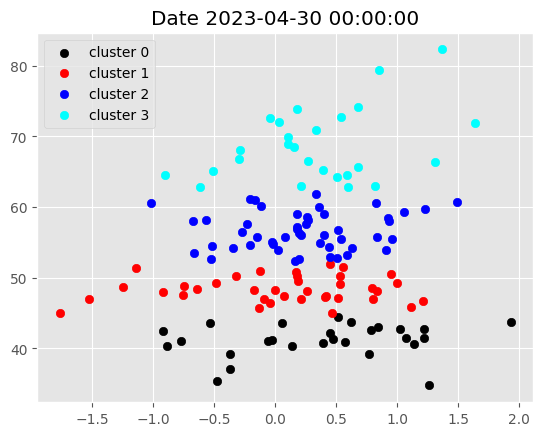

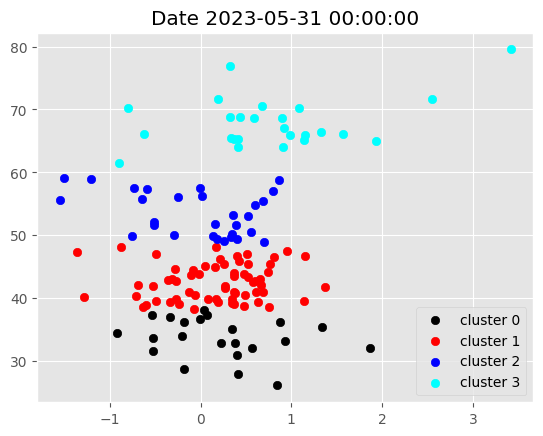

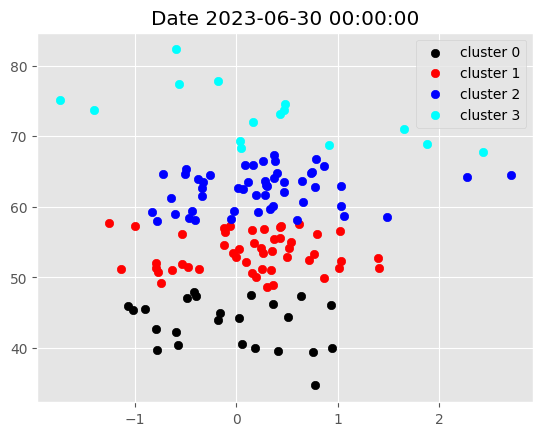

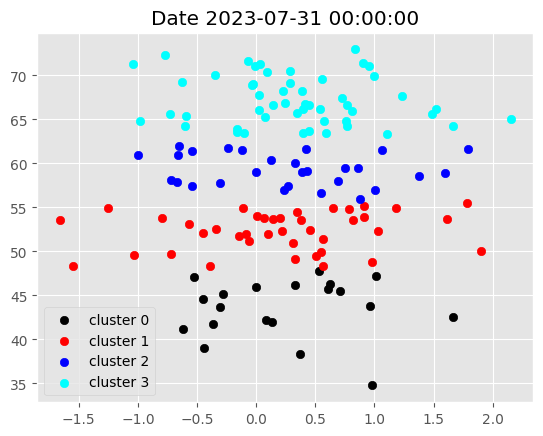

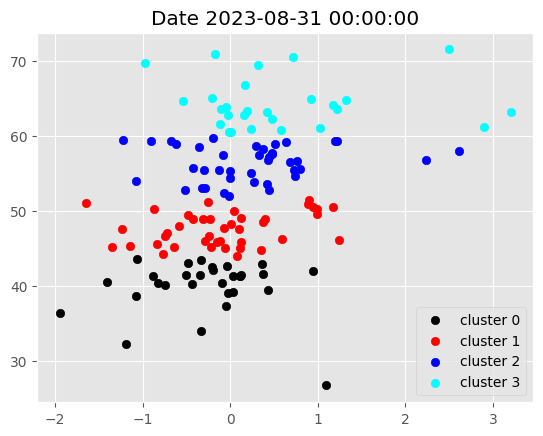

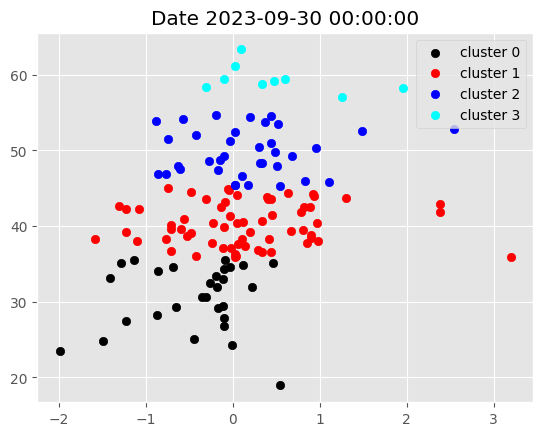

In [ ]:
plt.style.use('ggplot')

for i in data.index.get_level_values('date').unique().tolist():

    g = data.xs(i, level=0)

    plt.title(f'Date {i}')

    plot_clusters(g)

In [ ]:
target_rsi_values = [30, 45, 55, 70]

initial_centroids = np.zeros((len(target_rsi_values), 18))

initial_centroids[:, 6] = target_rsi_values

initial_centroids

array([[ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 45.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 55.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0., 70.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.]])

**7. For each month select assets based on the cluster and form a portfolio based on Efficient Frontier max sharpe ratio optimization**


**First we will filter only stocks corresponding to the cluster we choose based on our hypothesis.**

**Momentum is persistent and my idea would be that stocks clustered around RSI 70 centroid should continue to outperform in the following month - thus I would select stocks corresponding to cluster 3.**

In [ ]:
filtered_df = data[data['cluster']==3].copy()

filtered_df = filtered_df.reset_index(level=1)

filtered_df.index = filtered_df.index+pd.DateOffset(1)

filtered_df = filtered_df.reset_index().set_index(['date', 'ticker'])

dates = filtered_df.index.get_level_values('date').unique().tolist()

fixed_dates = {}

for d in dates:

    fixed_dates[d.strftime('%Y-%m-%d')] = filtered_df.xs(d, level=0).index.tolist()

fixed_dates

{'2017-11-01': ['AAPL',
  'ACN',
  'ADBE',
  'AMAT',
  'AMZN',
  'AVGO',
  'AXP',
  'BAC',
  'CAT',
  'COP',
  'CRM',
  'CTSH',
  'DE',
  'DHR',
  'DLTR',
  'ELV',
  'EOG',
  'GOOG',
  'GOOGL',
  'INTC',
  'ISRG',
  'JPM',
  'MA',
  'MAR',
  'MCD',
  'MET',
  'META',
  'MMM',
  'MPC',
  'MSFT',
  'MU',
  'NEE',
  'NVDA',
  'NXPI',
  'ORCL',
  'PYPL',
  'SHW',
  'STZ',
  'TXN',
  'UNH',
  'V',
  'VLO',
  'WMT',
  'XOM'],
 '2017-12-01': ['AMZN',
  'AXP',
  'AZO',
  'BA',
  'BAC',
  'BRK-B',
  'CAT',
  'COST',
  'CSCO',
  'DE',
  'DLTR',
  'ELV',
  'HD',
  'HON',
  'JPM',
  'KR',
  'LUV',
  'MAR',
  'MMM',
  'NKE',
  'ORLY',
  'OXY',
  'SCHW',
  'UNH',
  'UNP',
  'VLO',
  'VZ',
  'WMT'],
 '2018-01-01': ['BA',
  'CAT',
  'CVX',
  'DE',
  'FCX',
  'FDX',
  'HAL',
  'HD',
  'LOW',
  'LUV',
  'MAR',
  'OXY',
  'RTX',
  'STZ',
  'TXN',
  'UAL',
  'UNP',
  'VLO'],
 '2018-02-01': ['ABT',
  'ADBE',
  'AMZN',
  'BA',
  'BAC',
  'BRK-B',
  'CHTR',
  'CRM',
  'CTSH',
  'DG',
  'EA',
  'GD',
  'GOOG'

#**Define portfolio optimization function**
**We will define a function which optimizes portfolio weights using PyPortfolioOpt package and EfficientFrontier optimizer to maximize the sharpe ratio.**

**To optimize the weights of a given portfolio we would need to supply last 1 year prices to the function.**

**Apply signle stock weight bounds constraint for diversification (minimum half of equaly weight and maximum 10% of portfolio).**

In [ ]:
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models
from pypfopt import expected_returns

def optimize_weights(prices, lower_bound=0):

    returns = expected_returns.mean_historical_return(prices=prices,
                                                      frequency=252)

    cov = risk_models.sample_cov(prices=prices,
                                 frequency=252)

    ef = EfficientFrontier(expected_returns=returns,
                           cov_matrix=cov,
                           weight_bounds=(lower_bound, .1),
                           solver='SCS')

    weights = ef.max_sharpe()

    return ef.clean_weights()

**Download Fresh Daily Prices Data only for short listed stocks.**

In [ ]:
stocks = data.index.get_level_values('ticker').unique().tolist()

new_df = yf.download(tickers=stocks,
                     start=data.index.get_level_values('date').unique()[0]-pd.DateOffset(months=12),
                     end=data.index.get_level_values('date').unique()[-1])

new_df

[*********************100%%**********************]  155 of 155 completed


Price       Adj Close                                                 \
Ticker            AAL        AAPL        ABBV        ABT         ACN   
Date                                                                   
2016-10-31  39.134327   26.212477   39.878784  34.112480  103.117409   
2016-11-01  38.363209   25.739195   40.357777  33.947300  103.028694   
2016-11-02  38.276459   25.762289   40.600853  33.643040  105.219856   
2016-11-03  38.054207   25.486151   39.957432  33.364857  103.747253   
2016-11-04  38.402084   25.256414   40.064674  33.982071  103.995636   
...               ...         ...         ...        ...         ...   
2023-09-25  12.910000  175.386353  148.897141  95.484749  311.950897   
2023-09-26  12.700000  171.282578  148.184677  94.269997  305.672302   
2023-09-27  12.610000  169.758591  147.433685  93.584259  309.382446   
2023-09-28  12.920000  170.017578  146.586426  96.121506  295.988739   
2023-09-29  12.810000  170.535538  143.515091  94.877380  302.227997   

Price                                                                  ...  \
Ticker            ADBE         ADP        ADSK        AIG        AMAT  ...   
Date                                                                   ...   
2016-10-31  107.510002   73.831528   72.279999  50.462040   26.606323  ...   
2016-11-01  106.870003   73.712799   70.099998  49.627831   26.441635  ...   
2016-11-02  105.889999   76.307846   68.680000  49.521500   26.158010  ...   
2016-11-03  107.169998   75.756607   67.610001  47.558636   25.865225  ...   
2016-11-04  106.199997   75.544594   69.440002  46.928894   25.819477  ...   
...                ...         ...         ...        ...         ...  ...   
2023-09-25  511.600006  235.844086  205.669998  61.170822  135.818924  ...   
2023-09-26  506.299988  233.112457  201.660004  60.314251  133.323090  ...   
2023-09-27  502.600006  238.408691  202.279999  60.068115  134.297562  ...   
2023-09-28  504.670013  239.076843  207.889999  60.333946  137.439728  ...   
2023-09-29  509.899994  236.394333  206.910004  59.664444  137.668427  ...   

Price         Volume                                                           \
Ticker             V      VLO     VRTX        VZ       WBA      WDC       WFC   
Date                                                                            
2016-10-31  10024000  4969500  1928200  12459400   4662100  3363200  20115900   
2016-11-01  10881500  7816800  2458200  13229400   5130800  3821100  20020200   
2016-11-02   9170900  7317600  2580400  16488200   9783100  4216200  19566600   
2016-11-03   7563100  3855900  2371000  12605100   4586500  3192600  14982700   
2016-11-04   7588100  3729900  1902100  14410200   7023900  2705600  27391600   
...              ...      ...      ...       ...       ...      ...       ...   
2023-09-25   5921600  3241900   698100  17616900   6891000  2685900  10624000   
2023-09-26   6193200  4936800   633600  18841600   7570500  3571100  15219400   
2023-09-27   6006700  3644000   860600  22083500  10182900  2547800  11815500   
2023-09-28   4203900  3587300   578900  18772100   7291500  3282000  12454600   
2023-09-29   6044200  4302200   896800  19759400  25659100  2512000  13119100   

Price                                    
Ticker           WMT     WYNN       XOM  
Date                                     
2016-10-31  19167000  1341600  16663800  
2016-11-01  26515800  3722300  13050600  
2016-11-02  22935900  2542400  11226100  
2016-11-03  20411700  9050400   8836500  
2016-11-04  21786300  3223800  13877100  
...              ...      ...       ...  
2023-09-25  10459500  1387800  11316000  
2023-09-26  14435700  1454000  11805400  
2023-09-27  15711000  2050000  23976200  
2023-09-28  11617200  1290400  16808100  
2023-09-29  18842400  1326800  18810700  

[1740 rows x 930 columns]

**Calculate daily returns for each stock which could land up in our portfolio.**

**Then loop over each month start, select the stocks for the month and calculate their weights for the next month.**

**If the maximum sharpe ratio optimization fails for a given month, apply equally-weighted weights.**

**Calculated each day portfolio return.**

In [ ]:
# Calculate the portfolio weights for each month based on the clusters.

def optimize_weights(prices, lower_bound=0.01):
    mu = expected_returns.mean_historical_return(prices)
    S = risk_models.sample_cov(prices)
    ef = EfficientFrontier(mu, S, weight_bounds=(lower_bound, 1))
    weights = ef.max_sharpe()
    cleaned_weights = ef.clean_weights()
    return cleaned_weights

returns_dataframe = np.log(new_df['Adj Close']).diff()

portfolio_df = pd.DataFrame()

for start_date in fixed_dates.keys():
    try:
        end_date = (pd.to_datetime(start_date) + pd.offsets.MonthEnd(0)).strftime('%Y-%m-%d')
        cols = fixed_dates[start_date]

        optimization_start_date = (pd.to_datetime(start_date) - pd.DateOffset(months=12)).strftime('%Y-%m-%d')
        optimization_end_date = (pd.to_datetime(start_date) - pd.DateOffset(days=1)).strftime('%Y-%m-%d')

        optimization_df = new_df.loc[optimization_start_date:optimization_end_date, 'Adj Close'][cols]

        success = False
        try:
            weights = optimize_weights(prices=optimization_df, lower_bound=round(1/(len(optimization_df.columns)*2), 3))
            weights_df = pd.DataFrame([weights], index=[start_date])
            success = True
        except Exception as e:
            print(f'Max Sharpe Optimization failed for {start_date}, Continuing with Equal-Weights. Error: {e}')

        if not success:
            equal_weights = {col: 1/len(cols) for col in cols}
            weights_df = pd.DataFrame([equal_weights], index=[start_date])

        temp_df = returns_dataframe.loc[start_date:end_date, cols]

        weighted_returns = temp_df * weights_df.values
        temp_df['weighted_return'] = weighted_returns.sum(axis=1)
        temp_df = temp_df[['weighted_return']].rename(columns={'weighted_return': 'Strategy Return'})

        portfolio_df = pd.concat([portfolio_df, temp_df], axis=0)
    except Exception as e:
        print(f"Error processing date {start_date}. Error: {e}")

portfolio_df = portfolio_df.drop_duplicates()

In [ ]:
print("Final Portfolio Returns DataFrame:")
print(portfolio_df)

Final Portfolio Returns DataFrame:
Ticker      Strategy Return
Date                       
2017-11-01         0.001444
2017-11-02         0.003335
2017-11-03         0.006154
2017-11-06         0.003046
2017-11-07         0.003029
...                     ...
2023-09-25         0.006111
2023-09-26        -0.009816
2023-09-27         0.006339
2023-09-28         0.005605
2023-09-29        -0.003734

[1487 rows x 1 columns]


In [ ]:
spy = yf.download(tickers='SPY',
                  start='2015-01-01',
                  end=dt.date.today())

spy_ret = np.log(spy[['Adj Close']]).diff().dropna().rename({'Adj Close':'SPY Buy&Hold'}, axis=1)

portfolio_df = portfolio_df.merge(spy_ret,
                                  left_index=True,
                                  right_index=True)

portfolio_df

[*********************100%%**********************]  1 of 1 completed


,Strategy Return,SPY Buy&Hold_x,SPY Buy&Hold_y,SPY Buy&Hold
Date,,,,
2017-11-01,0.001444,0.001321,0.001321,0.001321
2017-11-02,0.003335,0.000388,0.000388,0.000388
2017-11-03,0.006154,0.003333,0.003333,0.003333
2017-11-06,0.003046,0.001546,0.001546,0.001546
2017-11-07,0.003029,-0.000696,-0.000696,-0.000696
...,...,...,...,...
2023-09-25,0.006111,0.004196,0.004196,0.004196
2023-09-26,-0.009816,-0.014800,-0.014800,-0.014800
2023-09-27,0.006339,0.000399,0.000399,0.000399


# Calculate key metrics

In [ ]:
# Calculate key metrics
def annualized_return(returns):
    return (1 + returns.mean()) ** 252 - 1

def annualized_volatility(returns):
    return returns.std() * np.sqrt(252)

def sharpe_ratio(returns):
    return returns.mean() / returns.std() * np.sqrt(252)

def max_drawdown(returns):
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    return drawdown.min()

annualized_return_value = annualized_return(portfolio_df['Strategy Return'])
annualized_volatility_value = annualized_volatility(portfolio_df['Strategy Return'])
sharpe_ratio_value = sharpe_ratio(portfolio_df['Strategy Return'])
max_drawdown_value = max_drawdown(portfolio_df['Strategy Return'])

In [ ]:
# SPY metrics

spy_metrics = {
    'Annualized Return': annualized_return(spy_ret['SPY Buy&Hold']),
    'Annualized Volatility': annualized_volatility(spy_ret['SPY Buy&Hold']),
    'Sharpe Ratio': sharpe_ratio(spy_ret['SPY Buy&Hold']),
    'Max Drawdown': max_drawdown(spy_ret['SPY Buy&Hold'])
}

portfolio_metrics = {
    'Annualized Return': annualized_return_value,
    'Annualized Volatility': annualized_volatility_value,
    'Sharpe Ratio': sharpe_ratio_value,
    'Max Drawdown': max_drawdown_value
}


In [ ]:
print(metrics_df)

                  Metric       SPY  Portfolio
0      Annualized Return  0.126487   0.199644
1  Annualized Volatility  0.178237   0.250926
2           Sharpe Ratio  0.668394   0.725673
3           Max Drawdown -0.357459  -0.268471


**Plot performance comparison**

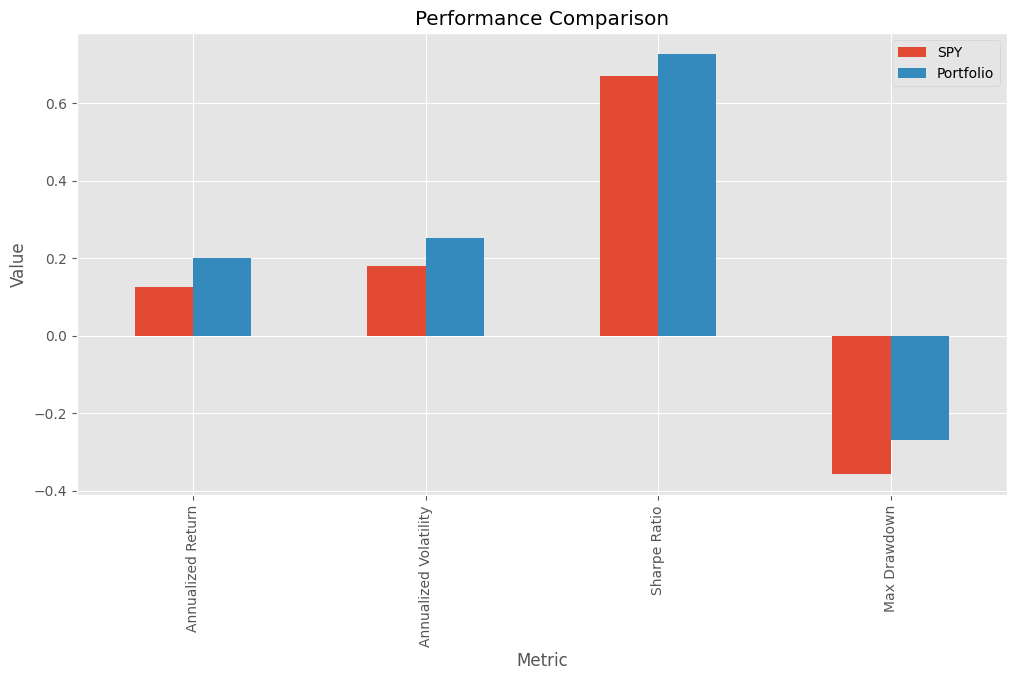

In [ ]:
# Plot performance comparison
metrics_df = pd.DataFrame({
    'Metric': ['Annualized Return', 'Annualized Volatility', 'Sharpe Ratio', 'Max Drawdown'],
    'SPY': [spy_metrics['Annualized Return'], spy_metrics['Annualized Volatility'], spy_metrics['Sharpe Ratio'], spy_metrics['Max Drawdown']],
    'Portfolio': [portfolio_metrics['Annualized Return'], portfolio_metrics['Annualized Volatility'], portfolio_metrics['Sharpe Ratio'], portfolio_metrics['Max Drawdown']]
})

metrics_df.plot(x='Metric', kind='bar', figsize=(12, 6), title='Performance Comparison')
plt.ylabel('Value')
plt.show()

**Calculate cumulative returns**

In [ ]:
# Calculate cumulative returns
portfolio_cumulative_return = np.exp(np.log1p(portfolio_df['Strategy Return']).cumsum()) - 1
spy_cumulative_return = np.exp(np.log1p(portfolio_df['SPY Buy&Hold']).cumsum()) - 1

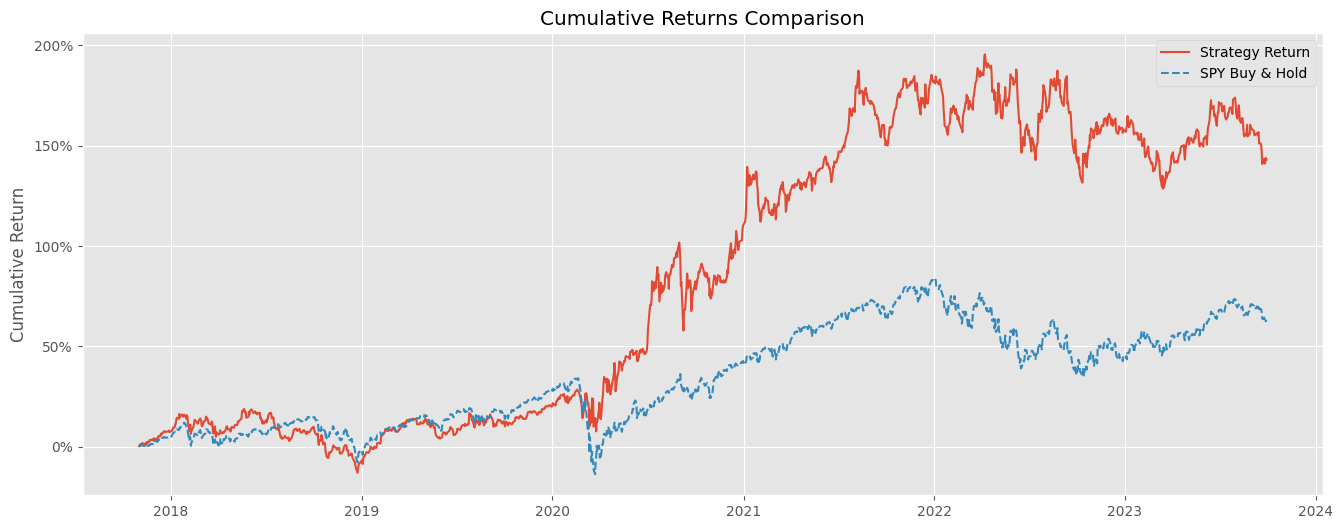

In [ ]:
import matplotlib.ticker as mtick
plt.style.use('ggplot')

# Plot portfolio cumulative returns
plt.figure(figsize=(16, 6))
plt.plot(portfolio_cumulative_return, label='Strategy Return')
plt.plot(spy_cumulative_return, label='SPY Buy & Hold', linestyle='--')
plt.title('Cumulative Returns Comparison')
plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1))
plt.ylabel('Cumulative Return')
plt.legend()
plt.show()
